In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import itertools


In [13]:
# import warnings
# # Ignore warnings
# warnings.filterwarnings("ignore")

In [14]:
filename = 'NSEI'
df = pd.read_csv(filename + '.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Date'])

In [15]:
df = df[(df['Date'].dt.dayofweek !=5) &(df['Date'].dt.dayofweek) !=6]
df = df.dropna(axis=0, how='all', subset=df.columns[1:])
df = df.sort_values(['Date'])

In [16]:
closing_prices = df["Close"]

In [17]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [18]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices.values.reshape(-1, 1))
# Divide data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[0:train_size, :], scaled_data[train_size:, :]
test_data_index = closing_prices[train_size:].index



In [19]:
def create_dataset(dataset, window_size=1):
    data_x, data_y = [], []
    for i in range(len(dataset) - window_size - 1):
        data_x.append(dataset[i:(i + window_size), 0])
        data_y.append(dataset[i + window_size, 0])
    return np.array(data_x), np.array(data_y)

In [20]:
window_size = 5
train_x, train_y = create_dataset(train_data, window_size)
test_x, test_y = create_dataset(test_data, window_size)
# Reshape input to [samples, time steps, features]
train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))

In [21]:
model = Sequential()
model.add(LSTM(50, input_shape=(1, window_size)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# Train LSTM model
model.fit(train_x, train_y, epochs=100, batch_size=1, verbose=0)

In [22]:
train_predict = model.predict(train_x)
test_predict = model.predict(test_x)
# Revert predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
train_y = scaler.inverse_transform([train_y])
test_predict = scaler.inverse_transform(test_predict)
test_y = scaler.inverse_transform([test_y])

In [26]:
test_rmse = sqrt(mean_squared_error(test_y[0], test_predict[:, 0]))
print("LSTM Test RMSE: ", test_rmse)

LSTM Test RMSE:  1035.2571521387008


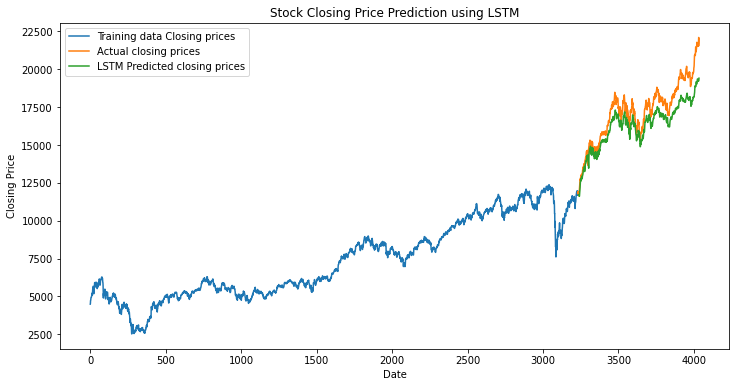

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(closing_prices[:-len(test_data_index)], label="Training data Closing prices")
plt.plot(closing_prices[-len(test_data_index):], label="Actual closing prices")
plt.plot(test_data_index[7:], test_predict[:-1], label="LSTM Predicted closing prices")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Stock Closing Price Prediction using LSTM")
plt.legend()
plt.show()